In [81]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import bs4 as bs
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier

## Data Exploration

In [8]:
!head -n2 data/labeledTrainData.tsv

id	sentiment	review
"5814_8"	1	"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual featu

In [9]:
train=pd.read_csv('data/labeledTrainData.tsv', delimiter='\t',header=0)
test=pd.read_csv('data/testData.tsv',delimiter='\t',header=0)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB


In [14]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


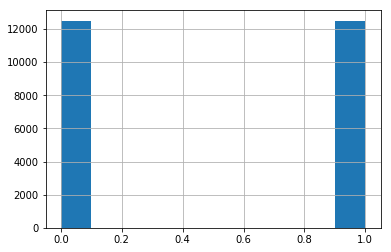

In [16]:
train.sentiment.hist()

## Feature Engineering

In [28]:
def clean_review(review):
    
    # remove HTML tags
    review = bs.BeautifulSoup(review).text
    
    # extract emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', review)
    
    #remove punctuations
    review = re.sub("[^a-zA-Z]"," ",review)
    
    #convert to lowercase
    review = review.lower()
    
    #tokenize to words
    review = review.split()
    
    #remove stopwords
    eng_stopwords = set(stopwords.words("english"))
    review = [w for w in review if not w in eng_stopwords]
   
    # join the review to one sentence
    review = ' '.join(review+emoticons)
    # add emoticons to the end
    
    return(review)
    
    
    

In [98]:
train['review_cleaned'] = train['review'].map(lambda x: clean_review(x))
test['review_cleaned'] = test['review'].map(lambda x: clean_review(x))

In [99]:
test.head()

,id,review,review_cleaned
0,12311_10,Naturally in a film who's main themes are of m...,naturally film main themes mortality nostalgia...
1,8348_2,This movie is a disaster within a disaster fil...,movie disaster within disaster film full great...
2,5828_4,"All in all, this is a movie for kids. We saw i...",movie kids saw tonight child loved one point k...
3,7186_2,Afraid of the Dark left me with the impression...,afraid dark left impression several different ...
4,12128_7,A very accurate depiction of small time mob li...,accurate depiction small time mob life filmed ...


In [88]:
train_1 = train[train['sentiment']==1]
train_0 = train[train['sentiment']==0]

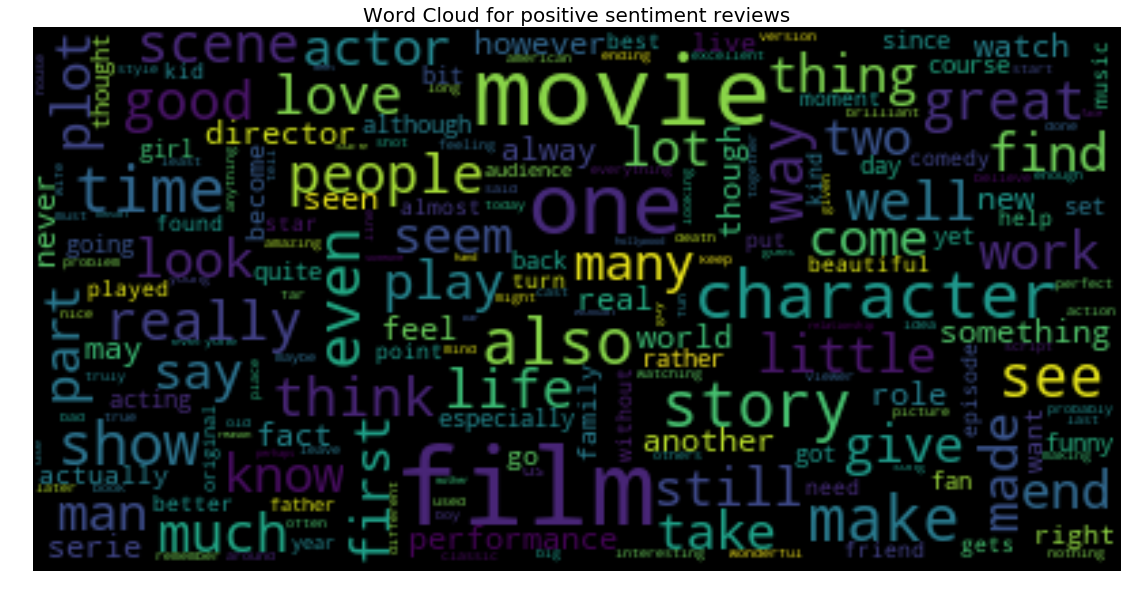

In [94]:
# Generate WordCloud for positive reviews

wordcloud = WordCloud(max_font_size=40).generate(''.join(train_1['review_cleaned'] ))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title ('Word Cloud for positive sentiment reviews', fontsize=20)
plt.axis("off")
plt.show()

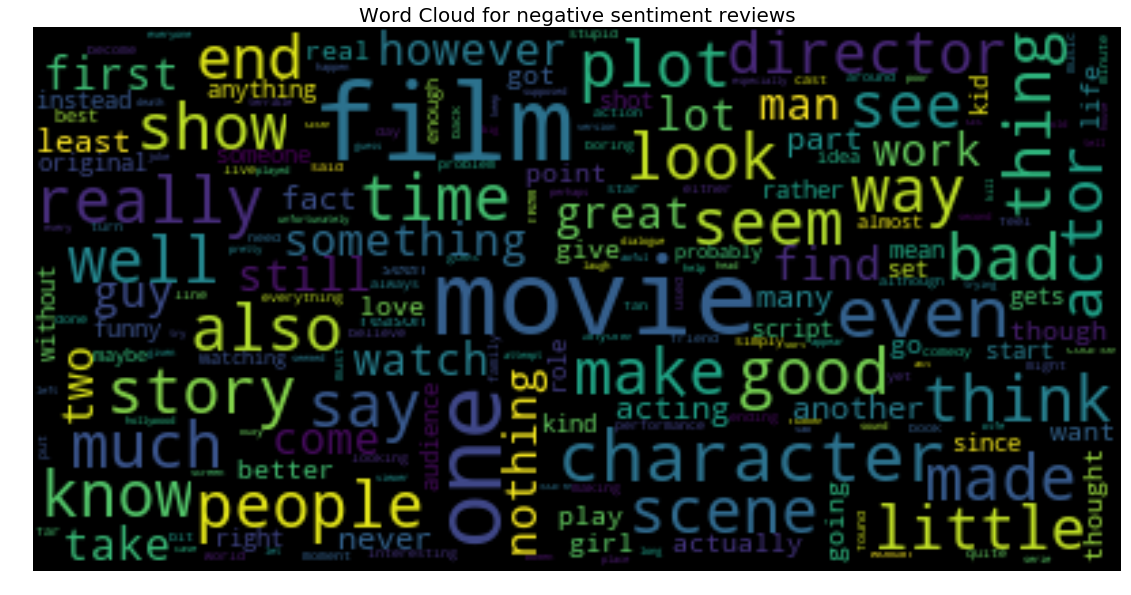

In [95]:
# Generate WordCloud for negative reviews

wordcloud = WordCloud(max_font_size=40).generate(''.join(train_0['review_cleaned'] ))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title ('Word Cloud for negative sentiment reviews', fontsize=20)
plt.axis("off")
plt.show()

In [33]:
# train test split
X_train, X_test, Y_train, Y_test = train_test_split(train['review_cleaned'],train['sentiment'],random_state=0, test_size=0.2)

In [41]:
# Count Vectorizer
vect = CountVectorizer(analyzer="word",max_features=5000)
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [42]:
vect.get_feature_names()[:10]

['abandoned',
 'abc',
 'abilities',
 'ability',
 'able',
 'abraham',
 'absence',
 'absent',
 'absolute',
 'absolutely']

In [44]:
train_bag = vect.transform(X_train)
test_bag = vect.transform(X_test)

In [45]:
print(train_bag.toarray().shape)
print(test_bag.toarray().shape)

(20000, 5000)
(5000, 5000)


## Random Forest Model

In [85]:
forest = RandomForestClassifier(n_estimators = 50) 

In [96]:
forest = forest.fit(train_bag, Y_train)

In [97]:
# Make predictions
train_predictions = forest.predict(train_bag)
valid_predictions = forest.predict(test_bag)

## Analysis 

In [102]:
# Training accuracy
metrics.accuracy_score(Y_train,train_predictions)

1.0

In [104]:
# Test accuracy
metrics.accuracy_score(Y_test,valid_predictions)

0.83599999999999997

In [106]:
# Confusion matrix
metrics.confusion_matrix(Y_test,valid_predictions)

array([[2150,  398],
       [ 422, 2030]])

In [107]:
# Extract feature importance
importances = forest.feature_importances_
print(importances)

[  5.73700125e-05   4.02137983e-05   7.42897572e-05 ...,   2.25444298e-04
   1.80699846e-04   9.78763687e-05]


In [119]:
indices = np.argsort(importances)[::-1]
top_10 = indices[:10]
print([vect.get_feature_names()[ind] for ind in top_10])

['worst', 'bad', 'great', 'waste', 'awful', 'terrible', 'worse', 'boring', 'excellent', 'wonderful']


In [115]:
# Predict for test data 
test_features = vect.transform(test['review_cleaned'])
result = forest.predict(test_features)

In [116]:
test['sentiment'] = result

In [117]:
test.head()

,id,review,review_cleaned,sentiment
0,12311_10,Naturally in a film who's main themes are of m...,naturally film main themes mortality nostalgia...,1
1,8348_2,This movie is a disaster within a disaster fil...,movie disaster within disaster film full great...,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",movie kids saw tonight child loved one point k...,1
3,7186_2,Afraid of the Dark left me with the impression...,afraid dark left impression several different ...,1
4,12128_7,A very accurate depiction of small time mob li...,accurate depiction small time mob life filmed ...,1


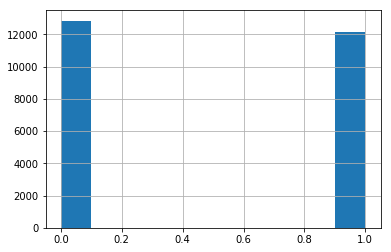

In [118]:
test.sentiment.hist()

In [120]:
test_1 = test[test['sentiment']==1]
test_0 = test[test['sentiment']==0]

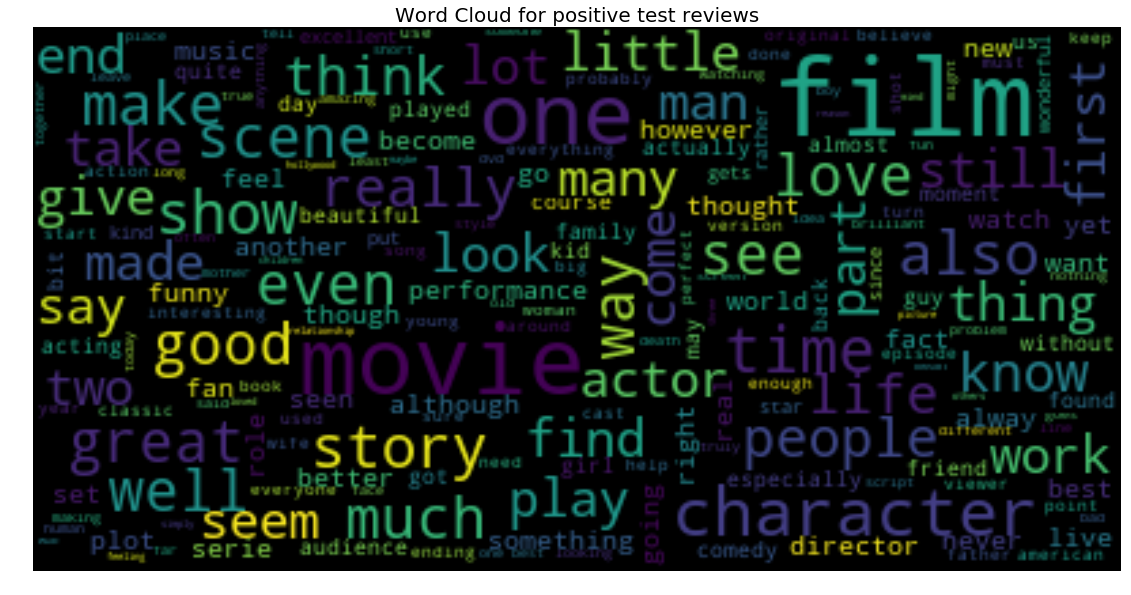

In [121]:
# Generate WordCloud for test reviews

wordcloud = WordCloud(max_font_size=40).generate(''.join(test_1['review_cleaned'] ))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title ('Word Cloud for positive test reviews', fontsize=20)
plt.axis("off")
plt.show()

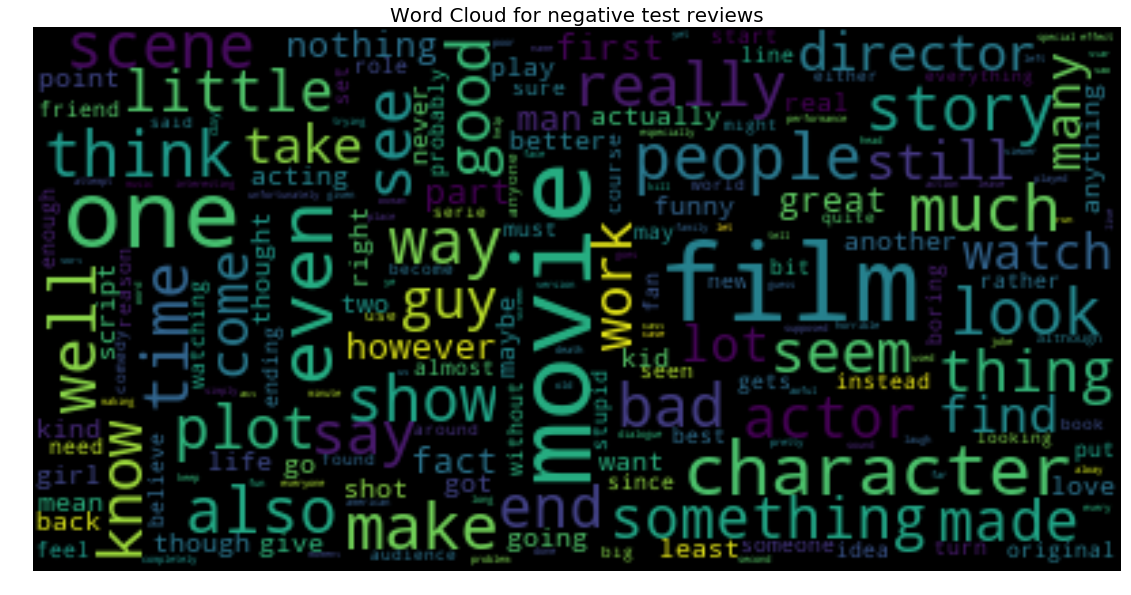

In [122]:
# Generate WordCloud for test reviews

wordcloud = WordCloud(max_font_size=40).generate(''.join(test_0['review_cleaned'] ))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title ('Word Cloud for negative test reviews', fontsize=20)
plt.axis("off")
plt.show()